# Artist Similarity with Graph Neural Network 2nd Notebook

In this notebook are shown the performances of the networks obtained from the training as described in the first notebook.  
In addition to the authors we have seen the quality of the recommended artists, with a query artists and the aid of the K-NN computation.  
It is in our interest to compare all the architectures and to see how the GAT ourtperforms in the results the GraphSAGE layer.

* Another important aspect that we see in this notebook is the possibility to create non-existing artists by only specifiyng fake relationship in the Graph with existing artists. The procedure is simple, we just create a feature vector for the fake artist and then we embed it with the other samples. This procedure also require that are specified one or more existing artist that are related to the fake one, in this way is possible to mix musical genres and see what are the recommended artists.

In [15]:
# !apt install cm-super
# ! sudo apt-get install texlive-latex-recommended 
# ! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
# ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
# ! unzip type1cm.zip -d /tmp/type1cm
# ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
# ! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
# ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
# ! sudo texhash 
# !pip install matplotlib==3.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 10.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.2.2-cp310-cp310-linux_x86_64.whl size=8622741 sha256=87ae0d5cf394e723604f4a9b70f4a4ec4998285b69d83c7f7041de49fd1ea737
  Stored in directory: /home/peppe/.cache/pip/wheels/bb/81/f3/48b8bd245846ae69fcb2281c84e848bfea1f5260a870c148ae
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import json
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import pairwise_euclidean_distance
from torch_geometric.nn import GATConv, SAGEConv
from torch.optim import lr_scheduler
import random
from random import choice,randrange
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import math
import time
from torch_geometric import seed_everything

random_seed=280085

seed_everything(random_seed)

/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1


In [2]:
from architectures import *
from utils import *

1.12.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

With the help of the [Torch geometric framework](https://pytorch-geometric.readthedocs.io/en/latest/) was really easy to handle the graph attributes and nodes and then the training of the GNNs.

In [4]:
X = torch.load('instance').T.to(device)      # Instance matrix
A = torch.load('adjacencyCOO').to(device)    # Adjacency matrix in the COO format, that is that supported by torch geometric
A1 = torch.load('adjacency').to(device)      # Normal adjacency matrix format is obtained with torch.load('adjacency')
num_samples = X.shape[0]
print(num_samples)

11261


In [5]:
filt = True


art_of_interest = torch.load('intrst_artists.pt')
labels = torch.load('labels.pt')
if filt:
  X = X[art_of_interest].detach()
  A1 = A1[art_of_interest, :][:, art_of_interest].detach()
  labels = labels[art_of_interest].detach()
  A = torch.nonzero(A1).T.type(torch.LongTensor).detach()

In [6]:
''' These variables contain the information about the artists' names, and their position in the dataset, this makes easy to look for their name and to better draw conclusions at inference time '''
num2artist = load_data('data/artist_genres.json')

num2artist = {key: num2artist[key][1] for key in num2artist}
artist2num = {num2artist[key]:key for key in num2artist}

##### Data in the dataset corrensponds to a set of artist, we have stored their names in two dictionaries. These two data structure are fundamental to keep track of their names and eventually to do more specific experiments.

## Import the data with Torch geometric:


In [7]:
''' In order to conduct the experiments was fundamental to split the dataset, either the nodes and also the edges.
    The splitting was performed according to the information in the paper, and considering the fact that a lot of date were lost in the preprocessing part.'''
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch_geometric.data import Data
from torch_geometric.utils import structured_negative_sampling
data = Data(x=X, edge_index = A).to(device)


In [8]:
# Number of layers #
# G1 = GraphSage(1)
# G2 = GraphSage(2)
# G3 = GraphSage(3)
n_heads = 1
n_layers = 2
GATm = GATSYFC(n_heads, n_layers)
load_model('./models/GATSY.pt', GATm, device)


{'loss_train': [2.4773150417539807,
  1.748911162217458,
  1.5860115885734558,
  1.5091288553343878,
  1.4460652603043451,
  1.432824108335707,
  1.3829878436194525,
  1.3396363523271348,
  1.3344598809878032,
  1.2859657605489094,
  1.2468823856777616,
  1.2122200263871088,
  1.2186521689097087,
  1.163508481449551,
  1.1488256123330858,
  1.1161361237366993,
  1.105948805809021,
  1.08142974641588,
  1.075261394182841,
  1.0762389202912648],
 'loss_test': [0.026277852555116017,
  0.023726988040531676,
  0.0273049542059501,
  0.027900919939080875,
  0.019417823059484363,
  0.02236774160216252,
  0.01691449185212453,
  0.013937514973804355,
  0.030375607932607334,
  0.028609815364082653,
  0.018687915056943893,
  0.024205774689714115,
  0.027689316620429356,
  0.011943826529507836,
  0.01106167157801489,
  0.012547614130501946,
  0.010203591004634896,
  0.010696170773978034,
  0.01600884273648262,
  0.010127008271714052],
 'accuracy': [0.5304588944550673,
  0.5384717021863155,
  0.5528

## What happens if we create an unreal artist?
* Since we are able now to embed artists, it is easy to augment our Graph Data Structure with new information, and we would expect to obtain plausible results as well.
* Thus we insert a new artist by specifying its connections in the graph, and then we compute its features as a linear combination of its neighbors features, namely the average.

* In the next cell we can either look for the neighbors of existing artist and also to create new artist and their neighborhoods.

In [9]:
def get_nearest_artists(embedding, artist_name, K, artist_to_id, id_to_artist):
  '''To get the nearest artist we use the K-NN algorithm:
      - embedding:   Is the embedding of artist,
      - artist_name: Query artist for which we are looking at its neighbors,
      - K:           Number of neighbors,
      - artist_to_id, and id_to_artist are the dictionary that keep track of the artists and their ids. '''
  Knew = K+50
  T=embedding.detach().to(torch.device("cpu")).numpy()
  neigh=NearestNeighbors(n_neighbors=Knew,algorithm='kd_tree').fit(T)#With the K-NN we get the nearest 
  if not filt:
    dist,ind = neigh.kneighbors(T[int(artist_to_id[artist_name])].reshape((1,-1)))
  else:
    idx = torch.nonzero(art_of_interest.where(art_of_interest == int(artist_to_id[artist_name]), torch.tensor([0]))).item()
    dist,ind = neigh.kneighbors(T[idx].reshape((1,-1)))


  neighbors_list = list(ind[0])[1:]
  dist_list = list(dist[0])[1:]
  neighbors_ = []
  c = 1
  while len(neighbors_)<K:
    if id_to_artist[str(neighbors_list[c])]!=None and id_to_artist[str(neighbors_list[c])] not in friend_artist_list:
      if not filt:
        neighbors_.append((id_to_artist[str(neighbors_list[c])],round(dist_list[c],4)))
        
      else:
        neighbors_.append((id_to_artist[str(art_of_interest[neighbors_list[c]].item())],round(dist_list[c],4)))


      c+=1
    else:
      c+=1

  #neighbors_list = [id_to_artist[str(artist)] for artist in neighbors_list if str(artist) in id_to_artist]
  
  return neighbors_

def get_embeddings(model, data):
  ''' This function simply computes the embeddings given a model name, and the data that we are using '''
  
  embedding = model(data.x, data.edge_index.to(device))

  return embedding

def add_new_artist(artist_query, friend_artist_list): 
  ''' This function augment the dataset if the artist_query is not already present in the dataset. 
      - artist_query:       artist for which we conduct the search,
      - friend_artist_list: list of correlated artists.                                            '''


  X_new = X.clone()
  A_new = A.clone()
  artist2num_new = artist2num.copy()
  num2artist_new = num2artist.copy()
  if artist_query not in artist2num and len(friend_artist_list) != 0:
    print("{} does not exist in  the dataset, or in real life. \n But we still can create it!".format(artist_query))
    artist2num_new[artist_query] = str(X_new.shape[0])
    num2artist_new[str(X_new.shape[0])] = artist_query
    feat_sum = torch.zeros(2613, device = device)
    for artist in friend_artist_list:
      if artist not in artist2num_new:
        print("{} is not in the dataset, so it is not valid for the neighbors list".format(artist))
      artist_num = artist2num_new[artist]
      A_new = torch.cat((A_new, torch.tensor([[int(artist2num_new[artist_query])],[int(artist2num_new[artist])]], device = device)), dim = 1)
      A_new = torch.cat((A_new, torch.tensor([[int(artist2num_new[artist])],[int(artist2num_new[artist_query])]], device = device)), dim = 1)
      feat_sum += X_new[int(artist2num_new[artist])]
    feat_sum /=len(friend_artist_list)
    X_new = torch.cat((X_new, feat_sum.unsqueeze(0)), dim = 0)

    data = Data(x=X_new, edge_index = A_new)
    print("\n{} has been created considering its neighbors:\n {}\n".format(artist_query, friend_artist_list))
  else:
    print("{} is an existing artist".format(artist_query))
    data = Data(x=X, edge_index = A)


  return data, artist2num_new, num2artist_new


data_n = data
artist2num_new = artist2num
num2artist_new = num2artist




Please run the 'friend_artist_list' before. Obviously it is required to specify the desired artist to correlate someone with the fictitious artist.

In [10]:
friend_artist_list = ['Ludwig van Beethoven']
embedding = get_embeddings(model = GATm.to(device), data = data_n)
artist_name = 'Ludwig van Beethoven'

if artist_name in list(artist2num_new.keys()):
    print(get_nearest_artists(embedding, artist_name, K = 10, artist_to_id = artist2num_new, id_to_artist = num2artist_new))
else:
    data_n, artist2num_new, num2artist_new = add_new_artist(artist_name, friend_artist_list = friend_artist_list)
    print('Run again the cell!!!')


[('Giacomo Puccini', 8.3253), ('The Pietasters', 8.6913), ('Scott Joplin', 8.7127), ('György Ligeti', 8.7353), ('The Slackers', 8.9221), ('Duquende', 9.0032), ('The Toasters', 9.0982), ('Stubborn All-Stars', 9.1432), ('Gian Carlo Menotti', 9.3106), ('Tim Armstrong', 9.3177)]


In [11]:
label_diz = load_data('data/encode_labels.json') # Genre to idx
label_diz2 = {label_diz[key] : key for key in label_diz} # Idx to genre
label_diz2

{'dance': '0',
 'metal': '1',
 'soul': '2',
 'folk': '3',
 'house': '4',
 'new wave': '5',
 'r&b': '6',
 'alternative rock': '7',
 'jazz': '8',
 'progressive rock': '9',
 'hip hop': '10',
 'rock': '11',
 'country': '12',
 'indie': '13',
 'pop': '14',
 'psychedelic rock': '15',
 'ambient': '16',
 'electronic': '17',
 'blues': '18',
 'punk': '19',
 'latin': '20',
 'reggae': '21',
 'funk': '22',
 'classical': '23',
 'hard rock': '24'}

In [17]:
label_diz

{'0': 'dance',
 '1': 'metal',
 '2': 'soul',
 '3': 'folk',
 '4': 'house',
 '5': 'new wave',
 '6': 'r&b',
 '7': 'alternative rock',
 '8': 'jazz',
 '9': 'progressive rock',
 '10': 'hip hop',
 '11': 'rock',
 '12': 'country',
 '13': 'indie',
 '14': 'pop',
 '15': 'psychedelic rock',
 '16': 'ambient',
 '17': 'electronic',
 '18': 'blues',
 '19': 'punk',
 '20': 'latin',
 '21': 'reggae',
 '22': 'funk',
 '23': 'classical',
 '24': 'hard rock'}

In [20]:
lista = [label_diz[str(l.item())] for l in labels]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


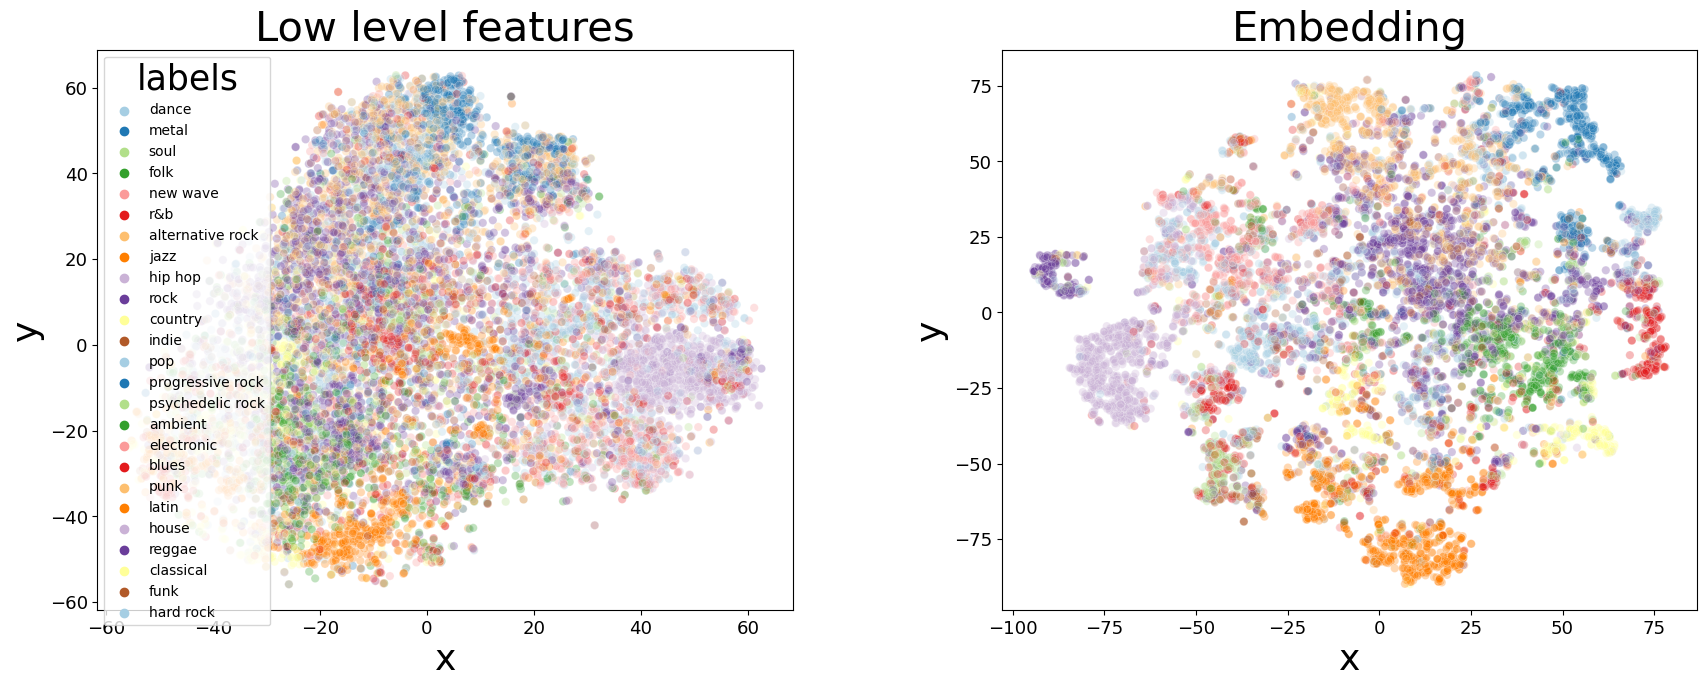

In [22]:
import seaborn as sns
import pandas as pd
from pylab import rcParams
from matplotlib import gridspec
import matplotlib
import matplotlib.font_manager
custom = sns.color_palette("Paired", 25)

import matplotlib.pyplot as plt
def plot_cluster(embedding1, embedding2, labels, n_clusters):
  DataF1 = pd.DataFrame()
  DataF1['x'] = embedding1[:,0]
  DataF1['y'] = embedding1[:,1]
  DataF1['labels'] = labels


  DataF2 = pd.DataFrame()
  DataF2['x'] = embedding2[:,0]
  DataF2['y'] = embedding2[:,1]
  DataF2['labels'] = labels

#   DataF3 = pd.DataFrame()
#   DataF3['x'] = embedding3[:,0]
#   DataF3['y'] = embedding3[:,1]
#   DataF3['labels'] = clust_obj1.predict(embedding_emb)

#   DataF4 = pd.DataFrame()
#   DataF4['x'] = embedding4[:,0]
#   DataF4['y'] = embedding4[:,1]
#   DataF4['labels'] = clust_obj2.predict(random_embedding_emb)
  
  fig1, axes1 = plt.subplots(1, 2, figsize=(20, 7))

  # fig1.suptitle('Representantion of the two types of input features, after the dimensionality reduction')
  sns.scatterplot(ax = axes1[0],
      x="x", y="y",
      data=DataF1,
      hue="labels",
      palette=custom,
      legend = 'full',
      alpha=0.3
  )

  axes1[0].set_title('Low level features')

  sns.scatterplot(ax = axes1[1],
      x="x", y="y",
      data=DataF2,
      hue="labels",
      palette=custom,
      legend = False,
      alpha=0.3
  )
  axes1[1].set_title('Embedding')
  # axes1[0].legend(title='', loc='upper left', labels=[label_diz[str(genre_idx)] for genre_idx in range(len(label_diz2))])

  plt.subplots_adjust(left=0.1,
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  wspace=0.3,
                  hspace=0.4)
  
  plt.savefig('comparisons.pdf')


  plt.show()
#   fig2, axes2 = plt.subplots(1, 2, figsize=(20, 7))
#   # fig2.suptitle('Representantion of the embeddings, after the dimensionality reduction')

#   sns.scatterplot(ax = axes2[0],
#       x="x", y="y",
#       data=DataF3,
#       hue="labels",
#       palette=sns.color_palette("hls", K),
#       legend=False,
#       alpha=0.3
#   )
#   axes2[0].set_title('Low level features')
#   sns.scatterplot(ax = axes2[1],
#       x="x", y="y",
#       data=DataF4,
#       hue="labels",
#       palette=sns.color_palette("hls", K),
#       legend=False,
#       alpha=0.3
#   )
#   axes2[1].set_title('Random features')
#   plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.4,
#                     hspace=0.4)
#   plt.savefig('dimred2.pdf')
#   plt.show()

  
params = {
   'axes.labelsize': 26,
   'font.family': 'Times New Roman',
   'font.size': 25,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'figure.figsize': [100*1.5, 95*1.5]
   }


rcParams.update(params)
matplotlib.rc('pdf', fonttype=42)
matplotlib.font_manager._rebuild()

instance_emb = torch.load('embeds/low_level.pt')
embedding_emb = torch.load('embeds/embedding_lab.pt')


# plot_cluster(new_emb, clustering, K, 'K-means clusters')
plot_cluster(np.array(instance_emb), np.array(embedding_emb), labels = lista, n_clusters = 25)
# plot_cluster(new_emb, gmm, K, 'Gaussian-Mixture clusters')
